### Boundary condition derivation for aquaplanet
This notebook derives the surface boundary condition for an aquaplanet. This boundary condition (referred to as sea-surface temperatures, or SSTs) is determined by the seasonal cycle from GFDL-CM2.5 runs, which in an atmosphere-only configuration, are determined by HadISST climatological SSTs.

In [1]:
''' Import packages. '''
# Time packages
import calendar, cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy, numba
# Local data storage packages
import functools, importlib, os, pickle, collections, sys

import pandas as pd, xarray as xr, nc_time_axis
xr.set_options(keep_attrs=True)
# Visualization tools
import cartopy, cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as plt

# Local imports
sys.path.insert(1, '/projects/GEOCLIM/gr7610/scripts')
import derived, utilities, visualization
importlib.reload(utilities);
importlib.reload(visualization);
importlib.reload(derived);

In [2]:
def generate_zonal_mean_SST(reference_SST: xr.Dataset,
                            processing_mode: str='sst',
                            rolling_mean_degrees: int|float=5,
                            interp_from_hadisst: bool=True):

    assert processing_mode in ['sst', 'ice']

    lon = reference_SST.lon.values
    lat = reference_SST.lat.values

    reference_SST_NEW = reference_SST.copy()

    # Interpolate SST from HadISST
    hadisst_SST_pathname = '/scratch/gpfs/GEOCLIM/gr7610/tiger3/CM2.5/INPUT/hadisst_sst.clim.1986-2005.zonal_mean.nc'
    hadisst_SST = xr.open_dataset(hadisst_SST_pathname)
    hadisst_SST['sst'] = hadisst_SST['sst'] - 273.15
    hadisst_SST_maxSST = hadisst_SST[processing_mode].max().item()
    
    hadisst_SST_interp = hadisst_SST.interp(lon=reference_SST_NEW.lon, 
                                            lat=reference_SST_NEW.lat,
                                            kwargs={"fill_value": "extrapolate"})
    
    # Create a container with empty data
    reference_SST_zonal_rolling_mean_container = np.full(shape=(len(reference_SST.time),
                                                                len(reference_SST.lat),
                                                                len(reference_SST.lon)), 
                                                         fill_value=np.nan)
    
    # Number of degrees to average over, in latitude
    n = 5
    # Iterate over all time indices
    for time_index in range(len(reference_SST.time)):
        # Obtain the iterand month
        month = reference_SST.isel(time=time_index).time.dt.month.item()
        # Handle SST zonal means
        if processing_mode == 'sst':
            if interp_from_hadisst:
                # Get zonal-mean SSTs from HadISST, if chosen (assumes only 12 entries are available)
                reference_SST_zonal_mean = hadisst_SST_interp[processing_mode].mean(dim='lon').isel(time=month-1)
            else:
                # Get zonal-mean SSTs
                reference_SST_zonal_mean = reference_SST[processing_mode].mean(dim='lon').isel(time=time_index)
            # Apply an n-degree centered rolling mean, w
            reference_SST_zonal_rolling_mean = reference_SST_zonal_mean.rolling(lat=(n*2), center=True).mean('lat')
            # Backfill null values with original data
            reference_SST_zonal_rolling_mean_2D = xr.where(reference_SST_zonal_rolling_mean.isnull(), reference_SST_zonal_mean, reference_SST_zonal_rolling_mean)
            # Append to the container
            reference_SST_zonal_rolling_mean_container[time_index, :, :] = np.repeat(reference_SST_zonal_rolling_mean_2D.values[np.newaxis, :], len(lon), axis=0).T
        # Handle ice cover and set to 0
        else:
            reference_SST_zonal_rolling_mean_container = np.full(shape=(len(reference_SST.time),
                                                                len(reference_SST.lat),
                                                                len(reference_SST.lon)), 
                                                         fill_value=0.0)
            
    reference_SST_zonal_mean = xr.DataArray(data=reference_SST_zonal_rolling_mean_container * hadisst_SST_maxSST / np.max(reference_SST_zonal_rolling_mean_container),
                                            coords={'time': (['time'], reference_SST.time.data),
                                                    'lat': (['lat'], reference_SST.lat.data),
                                                    'lon': (['lon'], reference_SST.lon.data)},
                                            dims=['time', 'lat', 'lon'])

    reference_SST_NEW[processing_mode] = reference_SST_zonal_mean

    # Copy the attributes
    reference_SST_NEW.attrs = hadisst_SST.attrs

    return reference_SST_NEW

In [45]:
def load_model_SST(model_name: str,
                   nx: int=360,
                   ny: int=180,
                   processing_mode: str='sst',
                   save_file: bool=False) -> xr.Dataset:


    ''' Function to load SSTs and save them to a file, if chosen. '''
    
    # Load sea-surface temperature data ('sst') at monthly frequency
    reference_pathname_monthly = f'/scratch/gpfs/GEOCLIM/gr7610/tiger3/util/input_data_AQP/input_v2025/amip1_{processing_mode}.data.nc'
    reference_SST = xr.open_dataset(reference_pathname_monthly).load()
    

    # Get zonal-mean SSTs
    reference_SST_zonal_mean = generate_zonal_mean_SST(reference_SST, processing_mode=processing_mode, interp_from_hadisst=True)
    reference_SST_zonal_mean = reference_SST_zonal_mean.interp(lon=np.arange(0, 360, 1, dtype=float), 
                                                               lat=np.arange(-90, 90, 1, dtype=float),
                                                               kwargs={"fill_value": "extrapolate"})
    
    # Define the reference pathname for saving the file
    pathname = f'/scratch/gpfs/GEOCLIM/gr7610/tiger3/{model_name}/INPUT/amip1_{processing_mode}.clim.zonal_mean.nc'

    # Define encoding for netCDF files for use in GFDL GCMs
    nc_encoding = {'time': {'dtype': 'double', '_FillValue': None, 
                            'calendar': 'gregorian'},
                   'lon': {'_FillValue': None}, 'lat': {'_FillValue': None},
                   processing_mode: {'dtype': 'float32', '_FillValue': None}}
    
    if save_file:
        reference_SST_zonal_mean.to_netcdf(pathname,
                                           encoding=nc_encoding,
                                           unlimited_dims='time')
        print(f'File saved to {pathname}!')

    return reference_SST_zonal_mean

In [46]:
def compare_AGCM_OBS_SST(min_SST: int|float|None=-2,
                         max_SST: int|float|None=None,
                         period: int|float=1.25,
                         power: int=2,
                         latitude_of_max_SST: int|float=15):

    ''' Compare observational and aquaplanet meridional SST profiles. '''

    ''' Get SST parameters. '''
    # Get zonal mean SST
    reference_SST_zonal_mean = load_model_SST()['sst'].mean(dim='lon')
    # Get maximum SST by time interval
    reference_SST_min = reference_SST_zonal_mean.where(reference_SST_zonal_mean == reference_SST_zonal_mean.min(dim='lat')).dropna(dim='lat', how='all').max(dim='lat')
    reference_SST_max = reference_SST_zonal_mean.where(reference_SST_zonal_mean == reference_SST_zonal_mean.max(dim='lat')).dropna(dim='lat', how='all').max(dim='lat')
    # Get latitude of maximum SST by time interval
    reference_SST_max_latitude = reference_SST_zonal_mean['lat'].where(reference_SST_zonal_mean == reference_SST_zonal_mean.max(dim='lat')).dropna(dim='lat', how='all').max(dim='lat')

    ''' Generate aquaplanet SST zonal mean distribution. '''
    min_SST = min_SST
    max_SST = reference_SST_max.max().item() if max_SST is None else max_SST
    latitude_offset = latitude_of_max_SST * np.pi/180 # C
    
    roots = [(np.pi/2 / period + latitude_offset) , (-np.pi/2 / period + latitude_offset)]
    
    minimum_latitude, maximum_latitude = min(roots), max(roots)
    [print(f'Root: {(root * 180 / np.pi):.3f}') for root in roots]
    
    func = lambda x, a, b, c, period, latitude_offset, minimum_latitude, maximum_latitude: np.where((x >= minimum_latitude) & 
                                                                                                    (x <= maximum_latitude),
                                                                                                    (a - b) * (1 - np.sin(period * x - period * latitude_offset)**c) + b,
                                                                                                    min_SST) # base function
    arr_x = np.deg2rad(reference_SST_zonal_mean.lat) # latitude range array
    
    ''' Plot meridional SST distribution as a function of month. '''
    
    # Get colormap and discrete colors for experiments
    line_colormap_name = 'twilight'
    line_colormap = matplotlib.colormaps[line_colormap_name]
    line_colormap = line_colormap(np.linspace(0, 1, len(reference_SST_zonal_mean.time)))

    # Initialize plot
    fig, ax = plt.subplots(figsize=(5, 2), dpi=144)
    
    ax.axvline(0, c='k', lw=1)

    # Plot the monthly-mean zonal-mean SSTs
    for month in range(len(reference_SST_zonal_mean.time)):
        ax.plot(reference_SST_zonal_mean.lat, 
                reference_SST_zonal_mean.isel(time=month), 
                lw=0.5, ls='--', c=(0.75, 0.75, 1))
        
    # Plot the idealized SST
    ax.plot(reference_SST_zonal_mean.lat, 
            func(reference_SST_zonal_mean.lat * np.pi/180, max_SST, min_SST, power, 
                 period, latitude_offset, minimum_latitude, maximum_latitude),
            lw=2, c='k')
    
    ax.set_title(f'SST distribution, peak offset of {(latitude_offset * 180 / np.pi):.2f}$\degree$', 
                 fontsize=9, ha='left', loc='left')
    ax.set_xticks(np.linspace(-90, 90, 13))
    
    ax.grid(ls='--')
    
    ax.set_xlim([-90, 90]);
    ax.set_xlabel('Latitude')
    ax.set_ylabel('SST [deg C]')

    return reference_SST_max

In [47]:
TMP = load_model_SST(model_name='HIRAM-AQP', save_file=True)

File saved to /scratch/gpfs/GEOCLIM/gr7610/tiger3/HIRAM-AQP/INPUT/amip1_sst.clim.zonal_mean.nc!


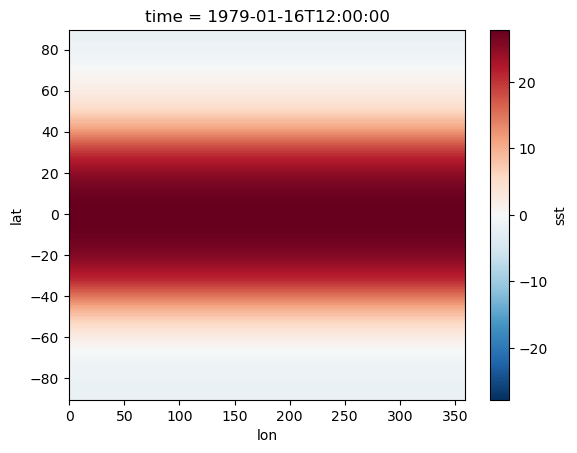

In [44]:
TMP['sst'].isel(time=0).interp(lon=np.arange(0, 360, 1, dtype=float), 
                               lat=np.arange(-90, 90, 1, dtype=float),
                               kwargs={"fill_value": "extrapolate"}).plot()

In [ ]:
reference_SST_max = compare_AGCM_OBS_SST(min_SST=0, 
                                         max_SST=None, 
                                         latitude_of_max_SST=0, 
                                         period=1.25,
                                         power=2,)

In [31]:
step = 0.5
lat = np.arange(-90, 90, step)
lon = np.arange(0, 360, step)

max_SST = reference_SST_max.max().item() # A
min_SST = max_SST - 7
period = 1.25 # B
latitude_offset = 15 * np.pi/180 # C
roots = ((np.pi/2 + latitude_offset) / period,
         (-np.pi/2 + latitude_offset) / period)

minimum_latitude = min(roots)
maximum_latitude = max(roots)

print(f'Maximum latitude at {(maximum_latitude * 180/np.pi):.3f}, minimum latitude at {(minimum_latitude * 180/np.pi):.3f}')

analytic_SST_funcs = {'Control': lambda x, a: np.where((x >= np.pi/3 + latitude_offset) & 
                                                       (x <= -np.pi/3 + latitude_offset),
                                                       a * (1 - np.sin(1.5 * x - latitude_offset)**4),
                                                       0),
                      'Custom': lambda x, a, b: np.where((x >= minimum_latitude) & 
                                                         (x <= maximum_latitude),
                                                         (a - b) * (1 - np.sin(period * x - latitude_offset)**2) + b,
                                                         b)}

Maximum latitude at 84.000, minimum latitude at -60.000


Text(0, 0.5, 'Latitude')

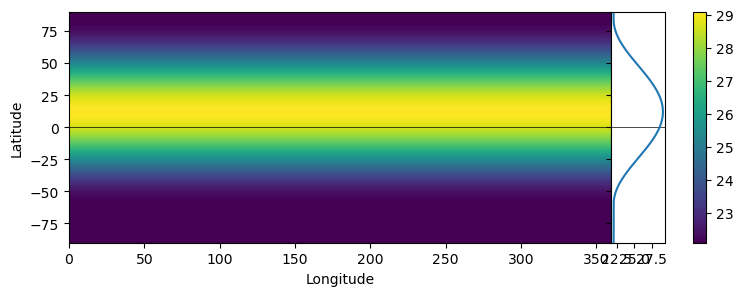

In [32]:
# Generate 2D temperature field
profile_SST = 'Custom' 
T = analytic_SST_funcs[profile_SST](lat * np.pi / 180, max_SST, min_SST)
distribution_SST_2D = np.repeat(T[np.newaxis, :], len(lon), axis=0).T

fig, ax = plt.subplots(figsize=(7, 3))

im = ax.pcolormesh(lon, lat, distribution_SST_2D)
ax.axhline(0, c='k', lw=0.5)

# Plot 1D zonal mean temperature
ax_zonal_mean = ax.inset_axes([1, 0, 0.1, 1])
ax_zonal_mean.axhline(0, c='k', lw=0.5)
ax_zonal_mean.plot(np.mean(distribution_SST_2D, axis=1), lat)
ax_zonal_mean.set_yticklabels([])

for axes in [ax, ax_zonal_mean]:
    axes.set_ylim([-90, 90])

cax = ax.inset_axes([1.15, 0, 0.025, 1])
colorbar = fig.colorbar(im, cax=cax)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')